In [1]:
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.pretraining import TabNetPretrainer
from models import UnsupervisedTBNet, supervisedTBNet
from utils import save2load_pretrain_model, feature_importances, calculate_scores

def normlize(df):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df =pd.DataFrame(df_scaled,columns=df.columns)
    return df

def df_preprocess(df):
    df["co_ran"]=df["co_max"]-df["co_min"]
    df["o3_ran"]=df["o3_max"]-df["o3_min"]
    df["so2_ran"]=df["so2_max"]-df["so2_min"]
    df["no2_ran"]=df["no2_max"]-df["no2_min"]
    df["temperature_ran"]=df["temperature_max"]-df["temperature_min"]
    df["pressure_ran"]=df["pressure_max"]-df["pressure_min"]
    df["humidity_ran"]=df["humidity_max"]-df["humidity_min"]
    df["fst_dir"]=df["co_var"]+df["so2_var"]+df["no2_var"]
    df = df.drop(drop_list2, axis=1)
    return df

drop_list=["id", "year", "Country", "City", "month", "day", "temperature_cnt",
           "humidity_cnt", "ws_cnt", "dew_cnt", "pressure_cnt"]

drop_list2=["humidity_max", "humidity_min", "temperature_min", "temperature_max",
           "humidity_min", "humidity_max", "humidity_mid", "pressure_min", "pressure_max", "pressure_mid",
            "ws_min", "ws_max", "ws_mid", "dew_min", "dew_max", "dew_mid"]

In [3]:
target_name = 'pm25_mid'
df = pd.read_csv('/Users/hagi/downloads/place/train.csv')
df = df.drop(drop_list, axis=1)
df = df_preprocess(df)
print(df.shape)
df.head()

(195941, 59)


,year,month,day,lat,lon,co_cnt,co_min,co_mid,co_max,co_var,...,dew_var,pm25_mid,co_ran,o3_ran,so2_ran,no2_ran,temperature_ran,pressure_ran,humidity_ran,fst_dir
0,2019,1,1,-27.46794,153.02809,38,0.749,2.590,2.633,0.850,...,13.424,19.901,1.884,3.519,0.751,2.188,9.910,19.261,63.995,2.154
1,2019,1,1,-12.46113,130.84185,47,2.594,3.181,4.828,1.208,...,2.021,13.741,2.234,9.240,16.056,5.312,12.565,141.915,43.941,69.159
2,2019,1,1,-37.81400,144.96332,17,1.190,1.197,2.200,0.248,...,6.355,25.918,1.010,22.696,46.260,11.258,23.226,138.200,74.081,546.336
3,2019,1,1,-32.92953,151.78010,63,4.586,11.044,14.802,24.186,...,9.417,174.370,10.216,36.457,11.099,9.262,3.621,6.661,26.496,70.699
4,2019,1,1,-31.95224,115.86140,47,4.689,8.681,11.100,10.011,...,4.109,167.063,6.411,38.251,9.550,17.673,3.080,8.090,44.615,93.543


In [4]:
N = int(len(df)*0.7)
N_ = int(len(df)*0.3)
X_train = df[:N]
X_test = df[N:N+N_]

In [5]:
# target value (No normalize)
X_trains = X_train.drop(target_name, axis=1).values
X_tests = X_test.drop(target_name, axis=1).values

# feature (No normalize)
y_train = X_train[target_name].values.reshape(X_train.shape[0], 1)
y_test = X_test[target_name].values.reshape(X_test.shape[0], 1)

print(X_trains.shape, X_tests.shape)
print(y_train.shape, y_test.shape)

(137158, 58) (58782, 58)
(137158, 1) (58782, 1)


In [6]:
# Unsupervised train
unvised = UnsupervisedTBNet(X_trains, X_tests)
unvised.unsupervised_train()

/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 212150.03938| val_0_unsup_loss_numpy: 87915.5390625|  0:00:16s
epoch 1  | loss: 165437.88168| val_0_unsup_loss_numpy: 91161.828125|  0:00:33s
epoch 2  | loss: 93045.10955| val_0_unsup_loss_numpy: 97613.34375|  0:00:50s
epoch 3  | loss: 27718.66941| val_0_unsup_loss_numpy: 96961.1796875|  0:01:07s
epoch 4  | loss: 916.90559| val_0_unsup_loss_numpy: 106310.7890625|  0:01:24s
epoch 5  | loss: 49.99996| val_0_unsup_loss_numpy: 56752.2421875|  0:01:41s
epoch 6  | loss: 25.35351| val_0_unsup_loss_numpy: 25871.263671875|  0:01:59s
epoch 7  | loss: 9.11342 | val_0_unsup_loss_numpy: 33956.61328125|  0:02:16s
epoch 8  | loss: 7.7953  | val_0_unsup_loss_numpy: 57290.08984375|  0:02:33s
epoch 9  | loss: 8.46688 | val_0_unsup_loss_numpy: 58829.875|  0:02:51s
epoch 10 | loss: 4.76031 | val_0_unsup_loss_numpy: 101259.03125|  0:03:08s
epoch 11 | loss: 3.82005 | val_0_unsup_loss_numpy: 84668.7109375|  0:03:25s

Early stopping occurred at epoch 11 with best_epoch = 6 and best_val_0_unsu

/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at ./test_pretrain.zip


/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


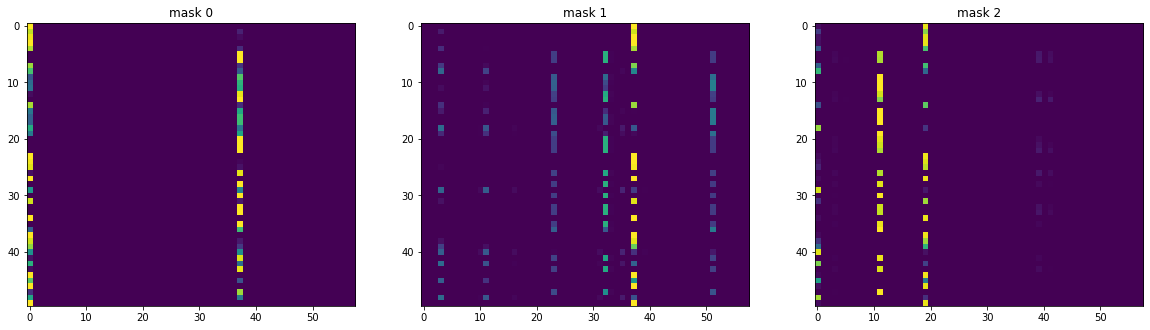

In [7]:
# Unsupervised predict
unsupervised_model = unvised.predict()
# save model
loaded_pretrain = save2load_pretrain_model(unsupervised_model, save=True)

total epoch 50


/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: cat_emb_dim changed from 1 to 3
  warnings.warn(wrn_msg)
/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_a changed from 15 to 8
  warnings.warn(wrn_msg)
/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_d changed from 15 to 8
  warnings.warn(wrn_msg)
/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: n_steps changed from 8 to 3
  warnings.warn(wrn_msg)
/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 20.94542| val_0_rmsle: 0.15826 | val_0_mae: 16.77532| val_0_rmse: 24.11449| val_0_mse: 581.50847|  0:00:42s
epoch 5  | loss: 16.1022 | val_0_rmsle: 0.14416 | val_0_mae: 15.36211| val_0_rmse: 22.0975 | val_0_mse: 488.29966|  0:04:17s
epoch 10 | loss: 15.74244| val_0_rmsle: 0.15002 | val_0_mae: 15.50381| val_0_rmse: 22.29275| val_0_mse: 496.96675|  0:07:54s
epoch 15 | loss: 15.51191| val_0_rmsle: 0.14793 | val_0_mae: 15.37235| val_0_rmse: 22.17425| val_0_mse: 491.69746|  0:11:30s
epoch 20 | loss: 15.35891| val_0_rmsle: 0.14202 | val_0_mae: 14.94686| val_0_rmse: 21.43057| val_0_mse: 459.26915|  0:15:06s
epoch 25 | loss: 15.23582| val_0_rmsle: 0.13367 | val_0_mae: 14.67007| val_0_rmse: 21.42714| val_0_mse: 459.12225|  0:18:41s
epoch 30 | loss: 15.15122| val_0_rmsle: 0.13918 | val_0_mae: 14.88167| val_0_rmse: 21.68563| val_0_mse: 470.26649|  0:22:17s
epoch 35 | loss: 15.09947| val_0_rmsle: 0.13778 | val_0_mae: 14.80411| val_0_rmse: 21.54889| val_0_mse: 464.35484|  0:25:53s


/Users/hagi/opt/anaconda3/envs/yolo/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


show feature importance


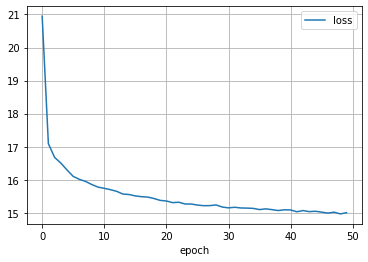

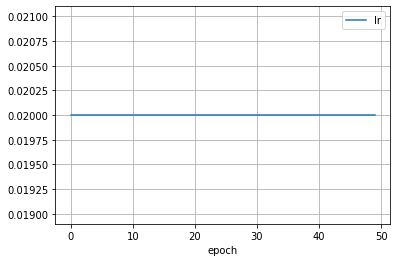

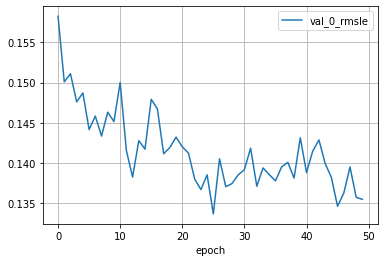

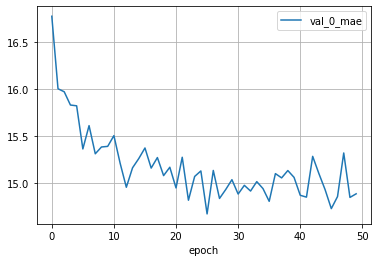

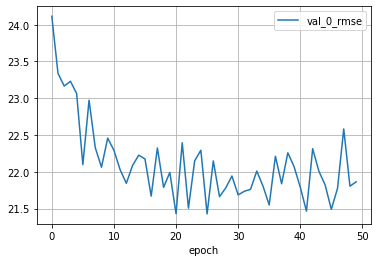

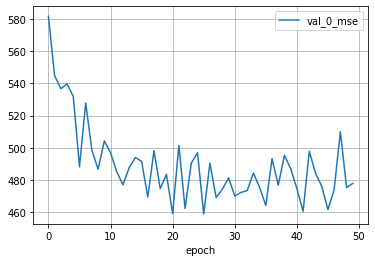

prediction


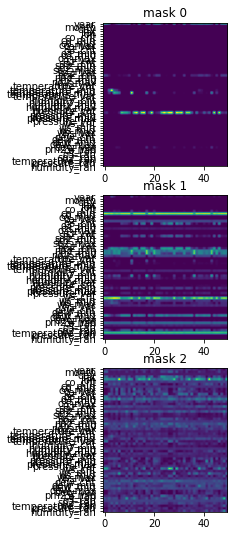

In [8]:
# supervised train
tbnet = supervisedTBNet(df, X_trains, X_tests, y_train, y_test,
                        target_name=target_name, loaded_pretrain=unsupervised_model, epochs=50)
model, pred, y_test = tbnet.train()

58


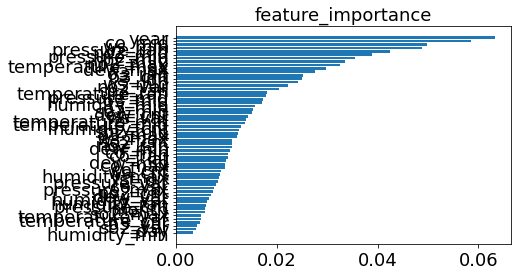

In [9]:
feature_importances(model, df, target_name)

In [10]:
scores = calculate_scores(y_test, pred)
scores

,R2,MAE,MSE,RMSE
scores,0.671369,14.670065,459.12225,21.427138


In [11]:
model.save_model('./test_trained')

Successfully saved model at ./test_trained.zip


'./test_trained.zip'

In [12]:
X_test = pd.read_csv('/Users/hagi/downloads/place/test.csv')
X_test = X_test.drop(drop_list, axis=1)
X_test = df_preprocess(X_test)
y_test = model.predict(X_test.values)
y_test.shape

(53509, 1)

In [13]:
dd = pd.DataFrame(y_test)
dd.set_index(dd.index+195942).to_csv("submit_0.csv", header=False)